In [22]:
!pip install arch
from arch import arch_model



[notice] A new release of pip is available: 24.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
"""
Hybrid GARCH(1,1) + Conv1d Neural Network Model with Dynamic Volatility Layer

The NN learns a persistence parameter C = α + β and a split factor ρ from historical data.
From (C, ρ) it reconstructs (α, β), which are then passed with ω to a differentiable GARCH
layer to predict the next conditional variance.

This implementation includes:
- Proper train/validation/test split
- Global standardisation of returns before NN and arch_model
- Training on log-variance log(σ²) instead of raw σ²
- Extensive diagnostic visualizations
- Parameter learning tracking over epochs
- Extra plots: α_true vs α_pred on train / val / test
"""

from arch import arch_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List
import torch.nn.functional as F
from torch.utils.data import Dataset

# Syntetics DATA

In [24]:
class GARCHGenerator:
    def __init__(self, omega, alpha, beta, n_samples, seed=42):
        assert omega > 0 and alpha >= 0 and beta >= 0 and alpha + beta < 1
        self.omega, self.alpha, self.beta = float(omega), float(alpha), float(beta)
        self.n_samples = int(n_samples)
        self.seed = int(seed)

    def generate_series(self, burn_in=200):
        torch.manual_seed(self.seed)
        sigma2 = self.omega / (1.0 - self.alpha - self.beta)  # sigma2_0

        returns, variances = [], []

        for _ in range(self.n_samples + burn_in):
            # sigma2_t -> génère r_t
            eps = torch.randn(1).item()
            r_t = float(np.sqrt(sigma2) * eps)

            returns.append(r_t)
            variances.append(float(sigma2))  # variance utilisée pour r_t

            # update -> sigma2_{t+1}
            sigma2 = self.omega + self.alpha * (r_t ** 2) + self.beta * sigma2

        # coupe burn-in sur les deux (même longueur)
        returns = returns[burn_in:]
        variances = variances[burn_in:]

        returns = torch.tensor(returns, dtype=torch.float32)
        variances = torch.tensor(variances, dtype=torch.float32)

        assert len(returns) == self.n_samples
        assert len(variances) == self.n_samples

        return returns, variances




def compute_garch_variance_from_params(returns: np.ndarray, omega: float, alpha: float, beta: float) -> np.ndarray:
    """
    Recompute sigma2[t] from returns and params (aligné avec le dataset).
    sigma2[0] init inconditionnelle, puis:
      sigma2[t] = omega + alpha * returns[t-1]^2 + beta * sigma2[t-1], pour t>=1
    """
    T = len(returns)
    sigma2 = np.zeros(T, dtype=np.float64)

    if init_sigma2 is None:
        denom = max(1e-8, 1.0 - alpha - beta)
        init_sigma2 = omega / denom

    sigma2[0] = float(init_sigma2)

    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t-1] ** 2) + beta * sigma2[t-1]

    return sigma2


# Dataset multi-séries “sliding windows”

In [25]:
class MultiGARCHDataset(Dataset):
    def __init__(self, returns_mat, variances_mat, window_size: int, stride: int = 10):
        assert returns_mat.shape == variances_mat.shape
        self.returns = returns_mat
        self.variances = variances_mat
        self.W = int(window_size)
        self.stride = int(stride)

        self.n_series, self.T = self.returns.shape

        # dernier start autorisé (pour que t+W < T)
        self.max_start = self.T - self.W - 1
        if self.max_start < 0:
            raise ValueError(f"series_len={self.T} trop court pour window_size={self.W} (il faut T >= W+1)")

        # nombre de starts: 0, stride, 2*stride, ... <= max_start
        self.windows_per_series = self.max_start // self.stride + 1
        self.n_samples = self.n_series * self.windows_per_series

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        series_idx = idx // self.windows_per_series
        k = idx % self.windows_per_series

        t = k * self.stride
        # sécurité (optionnel)
        # assert t <= self.max_start

        x = self.returns[series_idx, t:t+self.W].unsqueeze(-1)  # [W,1]
        y = self.variances[series_idx, t+self.W]                # scalar
        return x, y


# NN + GARCH

In [26]:
# ============================================================================
# 2. NEURAL NETWORK FOR PARAMETER PREDICTION
# ===========================================================================

class GarchParamNet(nn.Module):
    def __init__(self, hidden=32, kernel=3, conv_layers=5):
        super().__init__()
        layers = []
        in_ch = 1

        for l in range(conv_layers):
            d = 2 ** l
            pad = d * (kernel - 1) // 2  # "same" for odd kernel

            layers += [
                nn.Conv1d(in_ch, hidden, kernel_size=kernel, padding=pad, dilation=d),
                nn.GroupNorm(num_groups=8, num_channels=hidden),
                nn.LeakyReLU(0.2),
            ]
            in_ch = hidden    # nn.BatchNorm1d(hidden)

        self.conv = nn.Sequential(*layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden, hidden // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )

        self.head_omega = nn.Linear(hidden // 2, 1)
        self.head_c     = nn.Linear(hidden // 2, 1)
        self.head_rho   = nn.Linear(hidden // 2, 1)

    def forward(self, x):  # x: [B,T,1]
        x = x.transpose(1, 2)          # [B,1,T]
        h = self.conv(x).mean(dim=2)   # [B,hidden] (global avg pool)  !!! change with attention pooling or GRU if bad result 
        h = self.fc(h)                 # [B,hidden//2]

        omega = F.softplus(self.head_omega(h)) + 1e-6
        C     = torch.sigmoid(self.head_c(h)) * 0.99
        rho   = torch.sigmoid(self.head_rho(h))

        alpha = C * rho
        beta  = C * (1 - rho)

        return omega.squeeze(-1), alpha.squeeze(-1), beta.squeeze(-1)


# ============================================================================
# 3. DIFFERENTIABLE GARCH VOLATILITY LAYER
# ============================================================================

class GarchVolLayer(nn.Module):
    def forward(self, r_window, omega, alpha, beta):
        r = r_window.squeeze(-1)  # [B,T]

        # init unconditional (broadcast ok)
        sigma2 = omega / (1 - alpha - beta + 1e-8)

        for t in range(r.size(1)):
            sigma2 = omega + alpha * (r[:, t] ** 2) + beta * sigma2

        # sécurité numérique (optionnel mais utile)
        sigma2 = torch.clamp(sigma2, min=1e-10)
        return sigma2


# ============================================================================
# 4. HYBRID MODEL: NN + GARCH VOLATILITY LAYER
# ============================================================================

class HybridGarch(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = GarchParamNet(hidden=hidden)
        self.vol = GarchVolLayer()

    def forward(self, r_window):
        omega, alpha, beta = self.net(r_window)
        sigma2 = self.vol(r_window, omega, alpha, beta)
        return sigma2, omega, alpha, beta


# Trainning 

In [27]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    eps = 1e-8

    total_loss = 0.0
    total_a = total_b = total_w = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)                    # [B,W,1]
        y = y.to(device).float()            # [B]

        pred_sigma2, omega, alpha, beta = model(x)

        loss = criterion(torch.log(pred_sigma2 + eps), torch.log(y + eps))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_w += omega.detach().mean().item() * bs
        total_a += alpha.detach().mean().item() * bs
        total_b += beta.detach().mean().item() * bs
        n += bs

    return total_loss / n, total_w / n, total_a / n, total_b / n


@torch.no_grad()
def validate_epoch(model, loader, device):
    model.eval()
    criterion = nn.MSELoss()
    eps = 1e-8

    total_loss = 0.0
    total_a = total_b = total_w = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).float()

        pred_sigma2, omega, alpha, beta = model(x)
        loss = criterion(torch.log(pred_sigma2 + eps), torch.log(y + eps))

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_w += omega.detach().mean().item() * bs
        total_a += alpha.detach().mean().item() * bs
        total_b += beta.detach().mean().item() * bs
        n += bs

    return total_loss / n, total_w / n, total_a / n, total_b / n


def train_hybrid_garch(model, train_loader, val_loader, n_epochs, lr, device, ckpt_path="hybrid_garch_pretrained_synth.pt"):
    
    optimizer = optim.Adam(
    model.parameters(), 
    lr=lr,
    weight_decay=1e-4  )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2)

    best_val = float("inf")
    history = {"train_loss": [], "val_loss": []}

    for ep in range(1, n_epochs + 1):
        tr_loss, tr_w, tr_a, tr_b = train_epoch(model, train_loader, optimizer, device)
        va_loss, va_w, va_a, va_b = validate_epoch(model, val_loader, device)
        scheduler.step(va_loss)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), ckpt_path)

        if ep == 1 or ep % 2 == 0:
            print(f"Epoch {ep:02d} | train={tr_loss:.6f} | val={va_loss:.6f} | "
                  f"alpha={va_a:.4f} beta={va_b:.4f} (val)")

    print(f"Best val loss = {best_val:.6f} (log-variance MSE)")
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    return history

# Base line

In [28]:
def arch_baseline_log_mse_per_series(returns_mat, vars_mat, window_size, fit_ratio=0.6, max_series=None):
    eps = 1e-8
    n_series, T = returns_mat.shape
    W = window_size

    if max_series is not None:
        n_series = min(n_series, int(max_series))

    max_start = T - W - 1
    idxs = np.arange(0, max_start + 1) + W
    fit_len = int(fit_ratio * T)

    mses = []
    for j in range(n_series):
        r = returns_mat[j].cpu().numpy()
        true_s2 = vars_mat[j].cpu().numpy()

        am = arch_model(r[:fit_len], vol="GARCH", p=1, q=1, mean="Zero", dist="normal", rescale=False)
        res = am.fit(disp="off")

        omega = res.params["omega"]
        alpha = res.params["alpha[1]"]
        beta  = res.params["beta[1]"]

        sigma2_hat = np.zeros(T, dtype=np.float64)
        # partie fit (filtrée)
        sigma2_hat[:fit_len] = (res.conditional_volatility ** 2)

        # continuation après fit_len
        s2 = sigma2_hat[fit_len - 1]
        for t in range(fit_len, T):
            s2 = omega + alpha * (r[t-1] ** 2) + beta * s2
            sigma2_hat[t] = s2

        mse_log = np.mean((np.log(sigma2_hat[idxs] + eps) - np.log(true_s2[idxs] + eps))**2)
        mses.append(mse_log)

    return float(np.mean(mses))


# TEST ZONE

In [29]:
#def main():
# ---------------- config ----------------
N_SERIES = 2000
N_SAMPLES = 2000 
WINDOW_SIZE = 80

TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2

HIDDEN_DIM = 32
BATCH_SIZE = 64  
N_EPOCHS = 3
LR = 5e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------- sample params (original scale) ----------
TRUE_OMEGAS = np.random.uniform(0.001, 0.05, size=N_SERIES)
TRUE_BETAS = np.random.uniform(0.01, 0.85, size=N_SERIES)
# keep alpha + beta < 0.99
TRUE_SUMS = np.random.uniform(TRUE_BETAS + 0.01, 0.99) 
TRUE_ALPHAS = TRUE_SUMS - TRUE_BETAS

# --------- generate multi-series ----------
all_returns = []
all_variances = []
for j in range(N_SERIES):
    gen = GARCHGenerator(TRUE_OMEGAS[j], TRUE_ALPHAS[j], TRUE_BETAS[j], n_samples=N_SAMPLES, seed=42+j)
    r, s2 = gen.generate_series()
    all_returns.append(r)
    all_variances.append(s2)


all_returns = torch.stack(all_returns, dim=0)     # [N_SERIES, N_SAMPLES]
all_variances = torch.stack(all_variances, dim=0) # [N_SERIES, N_SAMPLES]


# --------- time split (same series, different time blocks) ----------
idx = np.random.permutation(N_SERIES)
n_tr = int(TRAIN_SPLIT * N_SERIES)
n_va = int(VAL_SPLIT   * N_SERIES)

tr_ids = idx[:n_tr]
va_ids = idx[n_tr:n_tr+n_va]
te_ids = idx[n_tr+n_va:]

train_returns_raw = all_returns[tr_ids]   
val_returns_raw   = all_returns[va_ids]
test_returns_raw  = all_returns[te_ids]
train_vars_raw    = all_variances[tr_ids]
val_vars_raw      = all_variances[va_ids]
test_vars_raw     = all_variances[te_ids]

# --------- global standardization ----------
mean_r = train_returns_raw.mean()
std_r  = train_returns_raw.std()

train_returns = (train_returns_raw - mean_r) / (std_r + 1e-8)
val_returns   = (val_returns_raw   - mean_r) / (std_r + 1e-8)
test_returns  = (test_returns_raw  - mean_r) / (std_r + 1e-8)

train_vars = train_vars_raw / ((std_r + 1e-8)**2)
val_vars   = val_vars_raw   / ((std_r + 1e-8)**2)
test_vars  = test_vars_raw  / ((std_r + 1e-8)**2)

# Parameters GARCH Series

TRUE_OMEGAS_SCALED = TRUE_OMEGAS / (float(std_r) ** 2)
TRUE_ALPHAS_SCALED = TRUE_ALPHAS
TRUE_BETAS_SCALED  = TRUE_BETAS

# --------- datasets/loaders ----------
train_ds = MultiGARCHDataset(train_returns, train_vars, WINDOW_SIZE)
val_ds   = MultiGARCHDataset(val_returns,   val_vars,   WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# --------- train NN-GARCH ----------
model = HybridGarch(hidden=HIDDEN_DIM).to(device)
history = train_hybrid_garch(
    model, train_loader, val_loader,
    n_epochs=N_EPOCHS, lr=LR, device=device,
    ckpt_path="hybrid_garch_pretrained_synth.pt"
)

# --------- save full checkpoint (useful for real transfer) ----------
torch.save({
    "model_state": model.state_dict(),
    "window_size": WINDOW_SIZE,
    "hidden_dim": HIDDEN_DIM,
    "n_samples": N_SAMPLES,
    "mean_r": float(mean_r),
    "std_r": float(std_r),
}, "hybrid_garch_pretrained_synth_full.pt")
print("Saved: hybrid_garch_pretrained_synth_full.pt")

# --------- ARCH baseline comparison on validation ----------
try:
    mse_arch_val = arch_baseline_log_mse_per_series(val_returns, val_vars, WINDOW_SIZE, fit_ratio=0.6)
    print(f"ARCH baseline (val) log-MSE: {mse_arch_val:.6f}")

except Exception as e:
    print("ARCH baseline skipped (arch not available or error):", repr(e))


Device: cpu
Epoch 01 | train=0.139264 | val=0.074265 | alpha=0.3172 beta=0.4174 (val)
Epoch 02 | train=0.087663 | val=0.062107 | alpha=0.2870 beta=0.4879 (val)
Best val loss = 0.061826 (log-variance MSE)
Saved: hybrid_garch_pretrained_synth_full.pt
ARCH baseline (val) log-MSE: 0.004783


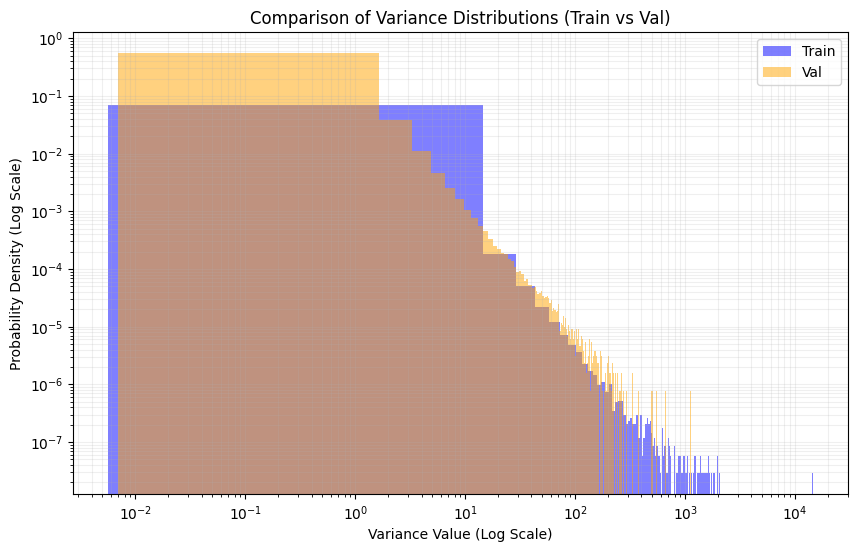

In [30]:
plt.figure(figsize=(10, 6))

# Histogram with 1000 bins and density normalization
plt.hist(train_vars.flatten(), bins=1000, alpha=0.5, label='Train', density=True, color='blue')
plt.hist(val_vars.flatten(), bins=1000, alpha=0.5, label='Val', density=True, color='orange')

# Logarithmic scales for better visualization of financial "fat tails"
plt.yscale('log')
plt.xscale('log')

# English Titles and Labels
plt.title('Comparison of Variance Distributions (Train vs Val)')
plt.xlabel('Variance Value (Log Scale)')
plt.ylabel('Probability Density (Log Scale)')

plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-", alpha=0.2) # Optionnel : ajoute une grille pour mieux lire le log

plt.show()

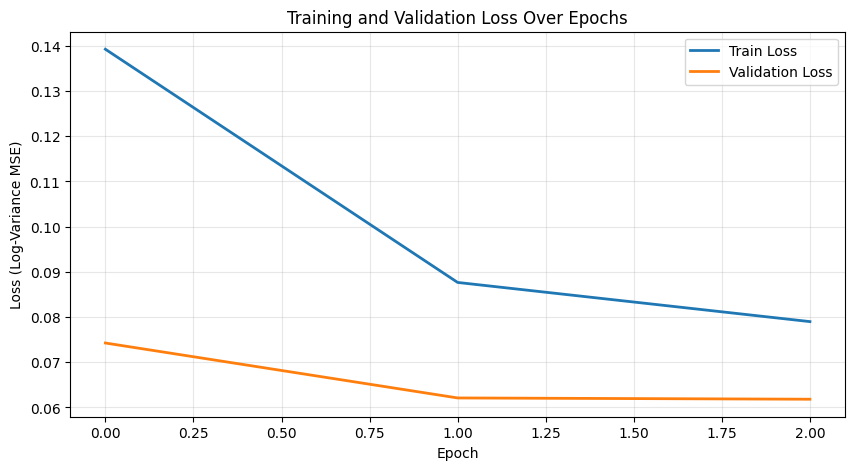

In [31]:
plt.figure(figsize=(10, 5))

# Plotting the loss history
plt.plot(history["train_loss"], label="Train Loss", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", linewidth=2)

# English Titles and Labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log-Variance MSE)')

plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

📊 Saved: nn_garch_diagnostics.png


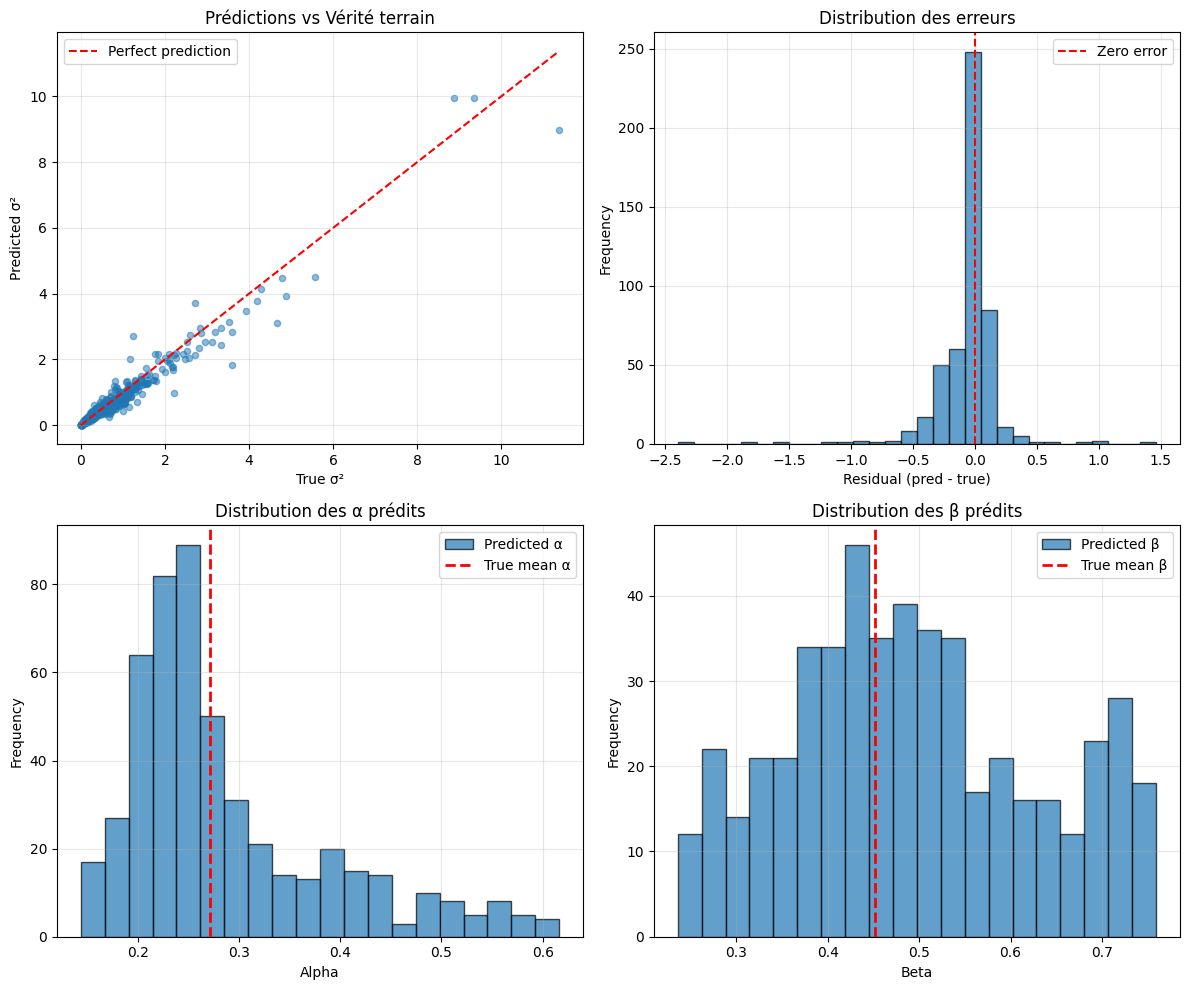


STATISTIQUES DE PRÉDICTION

MSE             : 0.069002
MAE             : 0.135293
R² score        : 0.9439

Mean |residual| : 0.135293
Std residual    : 0.256389

🎯 Paramètres moyens prédits :
   α = 0.2877 ± 0.1002
   β = 0.4920 ± 0.1345
   α+β = 0.7798


In [32]:
"""
Visualisation des prédictions NN-GARCH vs GARCH vrai
À ajouter dans ton notebook après l'entraînement
"""

import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_analysis(model, val_loader, device, n_examples=5):
    """
    Plot quelques exemples de prédictions vs vérité terrain
    """
    model.eval()
    
    examples = []
    with torch.no_grad():
        for x, y in val_loader:
            if len(examples) >= n_examples:
                break
            
            x = x.to(device)
            y = y.to(device)
            
            pred_sigma2, omega, alpha, beta = model(x)
            
            # Garder quelques samples
            for i in range(min(5, x.size(0))):
                examples.append({
                    'true': y[i].cpu().item(),
                    'pred': pred_sigma2[i].cpu().item(),
                    'omega': omega[i].cpu().item(),
                    'alpha': alpha[i].cpu().item(),
                    'beta': beta[i].cpu().item(),
                })
                if len(examples) >= n_examples:
                    break
    
    # Plot 1 : Scatter true vs pred
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    true_vals = [ex['true'] for ex in examples[:500]]  # Plus d'exemples
    pred_vals = [ex['pred'] for ex in examples[:500]]
    
    axes[0, 0].scatter(true_vals, pred_vals, alpha=0.5, s=20)
    axes[0, 0].plot([0, max(true_vals)], [0, max(true_vals)], 'r--', label='Perfect prediction')
    axes[0, 0].set_xlabel('True σ²')
    axes[0, 0].set_ylabel('Predicted σ²')
    axes[0, 0].set_title('Prédictions vs Vérité terrain')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2 : Résidus
    residuals = np.array(pred_vals) - np.array(true_vals)
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(0, color='r', linestyle='--', label='Zero error')
    axes[0, 1].set_xlabel('Residual (pred - true)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution des erreurs')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3 : Distribution des α prédits
    alphas = [ex['alpha'] for ex in examples]
    axes[1, 0].hist(alphas, bins=20, alpha=0.7, edgecolor='black', label='Predicted α')
    axes[1, 0].axvline(0.271, color='r', linestyle='--', linewidth=2, label='True mean α')
    axes[1, 0].set_xlabel('Alpha')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution des α prédits')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4 : Distribution des β prédits
    betas = [ex['beta'] for ex in examples]
    axes[1, 1].hist(betas, bins=20, alpha=0.7, edgecolor='black', label='Predicted β')
    axes[1, 1].axvline(0.452, color='r', linestyle='--', linewidth=2, label='True mean β')
    axes[1, 1].set_xlabel('Beta')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution des β prédits')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('nn_garch_diagnostics.png', dpi=150, bbox_inches='tight')
    print("📊 Saved: nn_garch_diagnostics.png")
    plt.show()
    
    # Statistiques
    print("\n" + "=" * 60)
    print("STATISTIQUES DE PRÉDICTION")
    print("=" * 60)
    print(f"\nMSE             : {np.mean((np.array(pred_vals) - np.array(true_vals))**2):.6f}")
    print(f"MAE             : {np.mean(np.abs(residuals)):.6f}")
    print(f"R² score        : {1 - np.var(residuals) / np.var(true_vals):.4f}")
    print(f"\nMean |residual| : {np.mean(np.abs(residuals)):.6f}")
    print(f"Std residual    : {np.std(residuals):.6f}")
    
    print(f"\n🎯 Paramètres moyens prédits :")
    print(f"   α = {np.mean(alphas):.4f} ± {np.std(alphas):.4f}")
    print(f"   β = {np.mean(betas):.4f} ± {np.std(betas):.4f}")
    print(f"   α+β = {np.mean(alphas) + np.mean(betas):.4f}")

# Utilisation (dans ton notebook après training) :
plot_predictions_analysis(model, val_loader, device, n_examples=500)

# Test Interpolation syntetic -> syntetic

In [40]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("hybrid_garch_pretrained_synth_full.pt", map_location=device)

WINDOW_SIZE = int(ckpt["window_size"])
HIDDEN_DIM  = int(ckpt["hidden_dim"])
mean_r      = float(ckpt["mean_r"])
std_r       = float(ckpt["std_r"])

model = HybridGarch(hidden=HIDDEN_DIM).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("Loaded model | window:", WINDOW_SIZE, "| hidden:", HIDDEN_DIM, "| std_r:", std_r)


Loaded model | window: 80 | hidden: 32 | std_r: 0.44620227813720703


In [41]:
def sample_interpolation_params(n_series, seed=123):
    rng = np.random.default_rng(seed)

    # Grilles (à adapter si tu veux)
    omega_grid = np.linspace(0.001, 0.05, 9)
    C_grid     = np.linspace(0.10, 0.98,  9)
    rho_grid   = np.linspace(0.05, 0.95,  9)

    # Interpolation = niveaux impairs (milieux)
    omega_levels = omega_grid[1::2]
    C_levels     = C_grid[1::2]
    rho_levels   = rho_grid[1::2]

    omegas = rng.choice(omega_levels, size=n_series, replace=True)
    Cs     = rng.choice(C_levels,     size=n_series, replace=True)
    rhos   = rng.choice(rho_levels,   size=n_series, replace=True)

    alphas = Cs * rhos
    betas  = Cs * (1 - rhos)
    return omegas, alphas, betas

# --- Génération synthétique interpolation ---
N_INTERP_SERIES = 400
N_SAMPLES = 2000
BURN_IN = 200

O_it, A_it, B_it = sample_interpolation_params(N_INTERP_SERIES, seed=999)

interp_returns_list, interp_vars_list = [], []
for j in range(N_INTERP_SERIES):
    gen = GARCHGenerator(O_it[j], A_it[j], B_it[j], n_samples=N_SAMPLES, seed=5000+j)
    r, s2 = gen.generate_series(burn_in=BURN_IN)
    interp_returns_list.append(r)
    interp_vars_list.append(s2)

interp_returns_raw = torch.stack(interp_returns_list, dim=0)  # [N_INTERP, T]
interp_vars_raw    = torch.stack(interp_vars_list, dim=0)

# Appliquer la même normalisation que le TRAIN (depuis le checkpoint)
interp_returns = (interp_returns_raw - mean_r) / (std_r + 1e-8)
interp_vars    = interp_vars_raw / ((std_r + 1e-8)**2)

interp_ds = MultiGARCHDataset(interp_returns, interp_vars, WINDOW_SIZE)
interp_loader = DataLoader(interp_ds, batch_size=64, shuffle=False, num_workers=0)

print("Interp shapes:", interp_returns.shape, interp_vars.shape)


Interp shapes: torch.Size([400, 2000]) torch.Size([400, 2000])


In [42]:
def eval_log_mse(model, loader, device):
    model.eval()
    eps = 1e-8
    loss_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float()
            sigma2_hat, omega, alpha, beta = model(x)
            loss = ((torch.log(sigma2_hat + eps) - torch.log(y + eps))**2).mean()
            bs = x.size(0)
            loss_sum += loss.item() * bs
            n += bs
    return loss_sum / max(1, n)

interp_loss = eval_log_mse(model, interp_loader, device)
print("NN interpolation log-MSE:", interp_loss)


NN interpolation log-MSE: 0.05882073970589166


In [43]:
mse_arch_interp = arch_baseline_log_mse_per_series(interp_returns[:100], interp_vars[:100], WINDOW_SIZE, fit_ratio=0.6)
print("ARCH interpolation log-MSE (100 series):", mse_arch_interp)


ARCH interpolation log-MSE (100 series): 0.00560779000617648


# Test Extrapolation 

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("hybrid_garch_pretrained_synth_full.pt", map_location=device)
WINDOW_SIZE = int(ckpt["window_size"])
HIDDEN_DIM  = int(ckpt["hidden_dim"])
mean_r      = float(ckpt["mean_r"])
std_r       = float(ckpt["std_r"])

model = HybridGarch(hidden=HIDDEN_DIM).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("Loaded | window:", WINDOW_SIZE, "| hidden:", HIDDEN_DIM, "| device:", device)


Loaded | window: 80 | hidden: 32 | device: cpu


In [ ]:
def sample_params_by_C(n_series, seed,
                       C_range,
                       rho_range=(0.05, 0.95),
                       vbar_range=(0.5, 5.0)):   # variance inconditionnelle cible
    rng = np.random.default_rng(seed)

    C   = rng.uniform(C_range[0], C_range[1], size=n_series)
    rho = rng.uniform(rho_range[0], rho_range[1], size=n_series)
    vbar = rng.uniform(vbar_range[0], vbar_range[1], size=n_series)

    alpha = C * rho
    beta  = C * (1 - rho)
    omega = vbar * (1 - C)

    return omega, alpha, beta, C


In [64]:
def make_synth_dataset(omegas, alphas, betas, n_samples=2000, burn_in=200, seed0=1000):
    returns_list, vars_list = [], []
    for j in range(len(omegas)):
        gen = GARCHGenerator(omegas[j], alphas[j], betas[j], n_samples=n_samples, seed=seed0 + j)
        r, s2 = gen.generate_series(burn_in=burn_in)
        returns_list.append(r)
        vars_list.append(s2)
    R = torch.stack(returns_list, dim=0)
    S2 = torch.stack(vars_list, dim=0)
    return R, S2

# -------- config ----------
N_TRAIN_SERIES = 2000
N_EXTRAP_SERIES = 400
N_SAMPLES = 2000
BURN_IN = 200
WINDOW_SIZE = 80
BATCH_SIZE = 64

# -------- sample train/extrap params ----------
O_tr, A_tr, B_tr, C_tr = sample_params_by_C(N_TRAIN_SERIES, seed=1, C_range=(0.05, 0.80))
O_ex, A_ex, B_ex, C_ex = sample_params_by_C(N_EXTRAP_SERIES, seed=2, C_range=(0.80, 0.99))

# -------- generate ----------
train_returns_raw, train_vars_raw = make_synth_dataset(O_tr, A_tr, B_tr, n_samples=N_SAMPLES, burn_in=BURN_IN, seed0=5000)
ex_returns_raw, ex_vars_raw       = make_synth_dataset(O_ex, A_ex, B_ex, n_samples=N_SAMPLES, burn_in=BURN_IN, seed0=9000)

# -------- normalize using TRAIN only ----------
mean_r = train_returns_raw.mean()
std_r  = train_returns_raw.std()

train_returns = (train_returns_raw - mean_r) / (std_r + 1e-8)
train_vars    = train_vars_raw / ((std_r + 1e-8)**2)

ex_returns = (ex_returns_raw - mean_r) / (std_r + 1e-8)
ex_vars    = ex_vars_raw / ((std_r + 1e-8)**2)

print("C_train min/mean/max:", C_tr.min(), C_tr.mean(), C_tr.max())
print("C_extrap min/mean/max:", C_ex.min(), C_ex.mean(), C_ex.max())


C_train min/mean/max: 0.05007203041999676 0.42596352744499777 0.7998433577023168
C_extrap min/mean/max: 0.8006054864174423 0.8941755744825446 0.9899920364308284


In [65]:
idx = np.random.permutation(N_TRAIN_SERIES)
n_tr = int(0.8 * N_TRAIN_SERIES)
tr_ids, va_ids = idx[:n_tr], idx[n_tr:]

train_ds = MultiGARCHDataset(train_returns[tr_ids], train_vars[tr_ids], WINDOW_SIZE)
val_ds   = MultiGARCHDataset(train_returns[va_ids], train_vars[va_ids], WINDOW_SIZE)
ex_ds    = MultiGARCHDataset(ex_returns, ex_vars, WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
ex_loader    = DataLoader(ex_ds,    batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


nn_val = eval_log_mse(model, val_loader, device)
nn_ex  = eval_log_mse(model, ex_loader,  device)
print("NN val (C<0.8) log-MSE:", nn_val)
print("NN extrap (C>0.8) log-MSE:", nn_ex)

mse_arch_ex = arch_baseline_log_mse_per_series(ex_returns[:100], ex_vars[:100], WINDOW_SIZE, fit_ratio=0.6)
print("ARCH extrap log-MSE (100 series):", mse_arch_ex)


NN val (C<0.8) log-MSE: 0.09051056373243531
NN extrap (C>0.8) log-MSE: 0.06942523198590303
ARCH extrap log-MSE (100 series): 0.005476782170891587


In [49]:
def eval_log_mse(model, loader, device):
    model.eval()
    eps = 1e-8
    s, n = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float()
            sigma2_hat, omega, alpha, beta = model(x)
            loss = ((torch.log(sigma2_hat + eps) - torch.log(y + eps))**2).mean()
            bs = x.size(0)
            s += loss.item() * bs
            n += bs
    return s / max(1, n)

nn_extrap = eval_log_mse(model, ex_loader, device)
print("NN extrapolation log-MSE:", nn_extrap)


NN extrapolation log-MSE: 0.16249870367348193


In [51]:
mse_arch_extrap = arch_baseline_log_mse_per_series(ex_returns, ex_vars, WINDOW_SIZE, fit_ratio=0.6)
print("ARCH extrapolation log-MSE (100 series):", mse_arch_extrap)


ARCH extrapolation log-MSE (100 series): 0.00869268608099056


In [52]:


@torch.no_grad()
def rolling_predict_sigma2(model, r_1d, window_size, device, batch_size=1024):
    """
    r_1d: np.array shape [T] (retours standardisés)
    Returns:
      pred_sigma2: np.array shape [T-window_size] correspondant à t = window_size..T-1
    """
    model.eval()
    r = torch.tensor(r_1d, dtype=torch.float32)

    T = r.shape[0]
    n = T - window_size
    preds = []

    for start in range(0, n, batch_size):
        end = min(n, start + batch_size)
        # windows: [B, W]
        windows = torch.stack([r[i:i+window_size] for i in range(start, end)], dim=0)
        windows = windows.unsqueeze(-1).to(device)   # [B, W, 1]

        sigma2_hat, omega, alpha, beta = model(windows)  # sigma2_hat: [B]
        preds.append(sigma2_hat.detach().cpu().numpy())

    return np.concatenate(preds, axis=0)  # [T-W]


In [53]:
j = 0  # index de série
r_series = ex_returns[j].cpu().numpy()     # [T] retours standardisés
s2_true  = ex_vars[j].cpu().numpy()        # [T] variances standardisées

W = WINDOW_SIZE
s2_pred = rolling_predict_sigma2(model, r_series, W, device)

t = np.arange(W, len(r_series))  # indices alignés (t = W..T-1)
s2_true_aligned = s2_true[W:]    # [T-W]


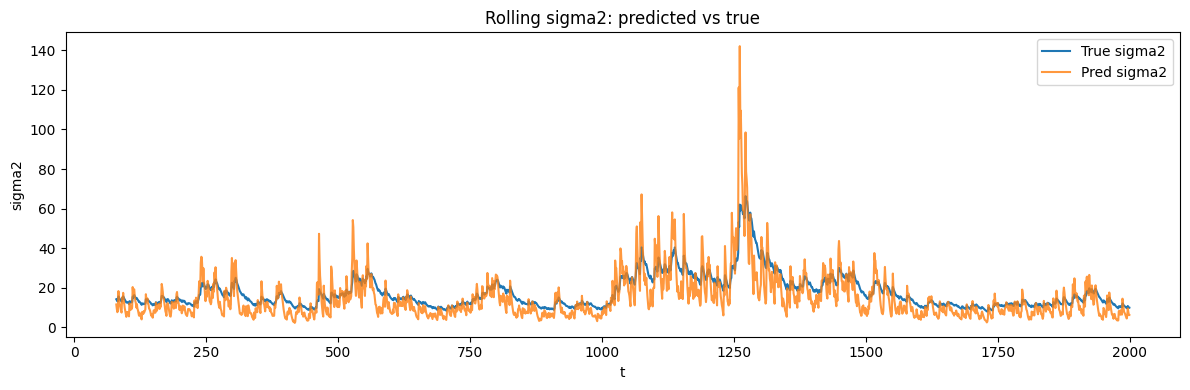

In [55]:
plt.figure(figsize=(12,4))
plt.plot(t, s2_true_aligned, label="True sigma2")
plt.plot(t, s2_pred, label="Pred sigma2", alpha=0.8)
plt.title("Rolling sigma2: predicted vs true")
plt.xlabel("t")
plt.ylabel("sigma2")
plt.legend()
plt.tight_layout()
plt.show()


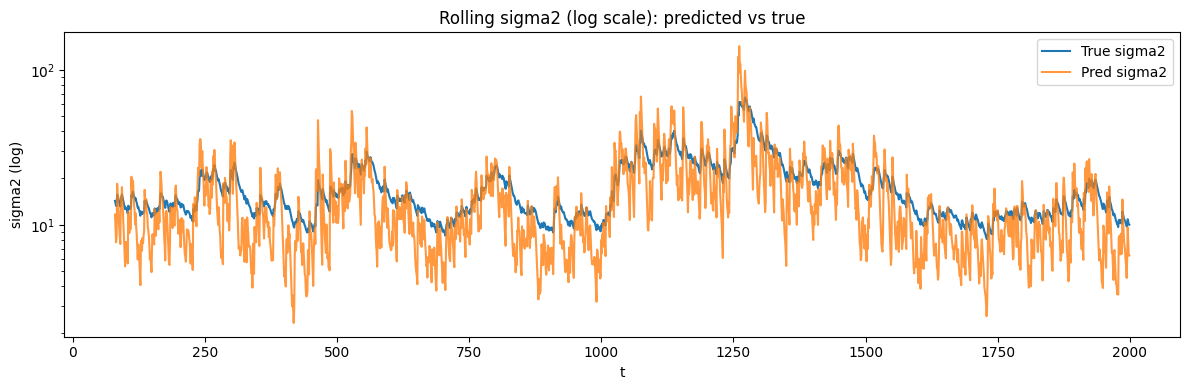

In [57]:
plt.figure(figsize=(12,4))
plt.plot(t, s2_true_aligned, label="True sigma2")
plt.plot(t, s2_pred, label="Pred sigma2", alpha=0.8)
plt.yscale("log")
plt.title("Rolling sigma2 (log scale): predicted vs true")
plt.xlabel("t")
plt.ylabel("sigma2 (log)")
plt.legend()
plt.tight_layout()
plt.show()


<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\karim\AppData\Local\Temp\ipykernel_3736\3396312047.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("True log($\sigma^2$)")
C:\Users\karim\AppData\Local\Temp\ipykernel_3736\3396312047.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Predicted log($\sigma^2$)")


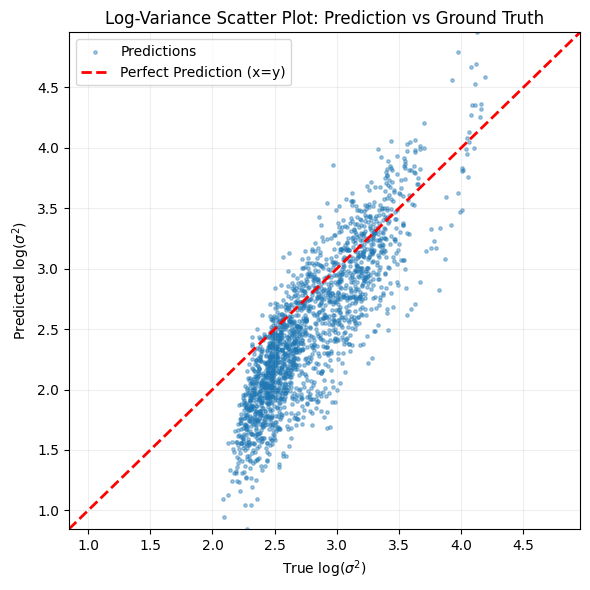

Log-MSE (this series): 0.201463


In [59]:

eps = 1e-8
# On prépare les données log
log_true = np.log(s2_true_aligned + eps)
log_pred = np.log(s2_pred + eps)

# Calcul des limites pour que le graphique soit carré et commence à 0 (ou au min des données)
# Note: log(1) = 0. Si vos variances sont < 1, le log sera négatif. 
# Si vous voulez forcer l'affichage à partir de 0 sur l'axe d'origine, 
# assurez-vous que vos données le permettent.
min_val = min(log_true.min(), log_pred.min())
max_val = max(log_true.max(), log_pred.max())

plt.figure(figsize=(6, 6)) # Carré pour que la pente 1 soit visuellement à 45°

plt.scatter(log_true, log_pred, s=6, alpha=0.4, label="Predictions", color='tab:blue')

# --- Ligne rouge de pente 1 passant par l'origine ---
# On trace de min_val à max_val pour couvrir toutes les données
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="Perfect Prediction (x=y)")

# --- Ajustements des axes ---
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.title("Log-Variance Scatter Plot: Prediction vs Ground Truth")
plt.xlabel("True log($\sigma^2$)")
plt.ylabel("Predicted log($\sigma^2$)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

log_mse = np.mean((log_pred - log_true)**2)
print(f"Log-MSE (this series): {log_mse:.6f}")